In [1]:
import numpy as np
from  matplotlib import pyplot as plt
from matplotlib import patches
import librosa
import librosa.display
import pandas as pd
import scipy
from scipy import ndimage
import time

from utils.plot_tools import *

import IPython.display as ipd
from IPython.display import Image, Audio

path_img = '../img/8.content-based_audio_retrieval/'
path_data = '../data_FMP/'

# Common Subsequence Matching

## Alignment Scenarios

- 우선 다양한 정렬(alignment) 시나리오와 그 이면의 원칙에 대해 간략하게 살펴보자. **시퀀스 정렬**의 일반적인 목적은 주어진 두 시퀀스 $X=(x_1,x_2,\ldots,x_N)$ 및 $Y=(y_1,y_2,\ldots,y_M)$이 공유하는 유사성 영역을 식별하는 것이다. 동시에, 일치하는 영역의 요소가 대응된다. 일반적으로 정렬의 두 범주인 **전역(global)** 정렬과 **로컬(local)** 을 구분할 수 있다. 전역의 경우, 정렬이 두 시퀀스의 전체 길이에 걸쳐 있도록 강제한다. 대조적으로, 로컬의 경우에, 일반적으로 광범위하게 발산하는 더 긴 시퀀스 내에서 유사성 영역을 식별하려고 시도한다.

    * 4장에서 동적 시간 워핑(DTW)을 다룰 때 워핑 경로의 개념에 의해 수학적으로 모델링된 전역적 정렬 기술을 접했다. 이 정의의 **경계 조건**(boundary condition)은 두 개의 지정된 시퀀스 $X$ 및 $Y$가 **전역적으로** 정렬되도록 했다. 또한 단계 크기 조건(step size condition)을 적절하게 수정하여 정렬의 연속성 정도를 조정할 수 있었다.

    * 오디오 매칭에 사용되는 하위 시퀀스(subsequence) DTW에서 두 시퀀스 $X$ 및 $Y$는 다른 방법을 사용해 다뤄졌다. 시퀀스 $X$는 전체적으로 정렬되어야 했지만 시퀀스 $Y$의 하위 시퀀스만 일치하는 대응 항목으로 충분했다. 따라서 이 시나리오에는 **혼합된 전역/로컬 정렬** 접근 방식이 필요했다. 기술적으로 시퀀스 $Y$에 대한 경계 조건을 완화하여 비용 없이 정렬에서 접미사(suffix)와 접두사(prefix)를 생략할 수 있도록 하는 것이었다.

- 이 노트북에서는 $X$ 및 $Y$ 두 시퀀스 모두에 대해 **매칭 하위 시퀀스**만 식별되는 **로컬 정렬** 문제를 처리한다. 매칭을 계산하기 위해 시퀀스 $X$ 및 $Y$ 모두에 대한 경계 조건이 제거된다. 
- 또한 두 번째 기술적 수정이 필요하다. 앞의 두 시나리오에서는 적어도 시퀀스 $X$의 측면에 전역적 제약이 있는 경우 비용 최소화 경로를 고려하여 정렬을 계산했다. 이제 전역 제약 조건이 없는 로컬 시나리오에서 이러한 접근 방식은 빈 정렬로 이어진다. 따라서 **양수 점수**(관련 정보) 및 **음수 점수**(관련 없는 정보)가 있는 **점수 매트릭스**를 기반으로 점수 최대화 정렬을 살펴봄으로써 다른 최적화 기준을 도입한다.

- 고려된 경계 조건 외에도 정렬 결과의 특성에 결정적으로 영향을 미치는 다른 요소가 있다. 예를 들어 **부분 매칭**(**partial matching**)에서는 단계 크기 조건을 제거하고 훨씬 더 약한 단조성 조건으로 대체한다. 

- 다음 그림은 서로 다른 정렬 시나리오 간의 개념적 차이점을 요약한 것이다.

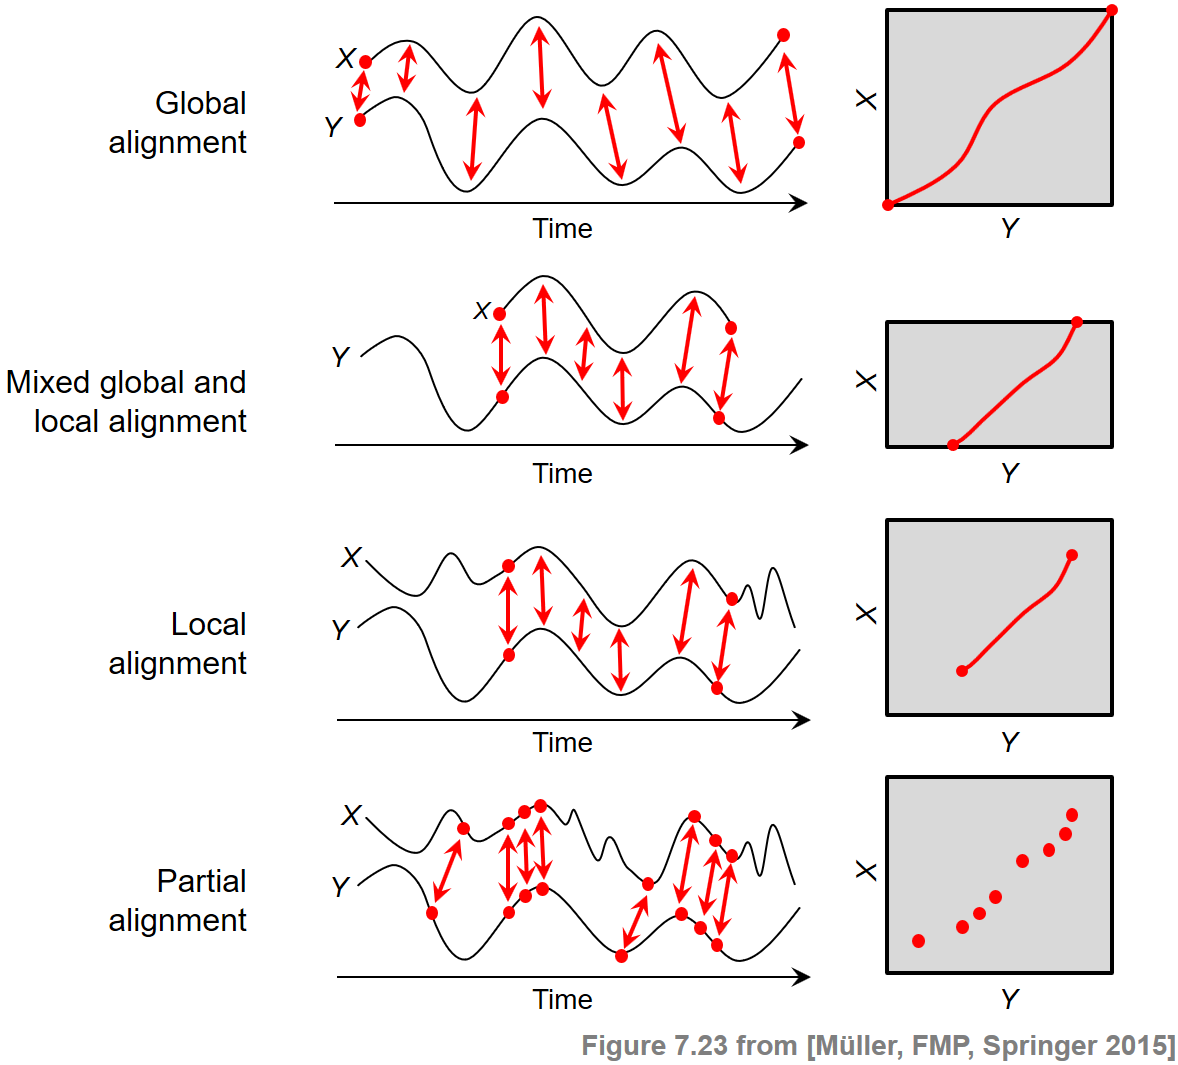

In [2]:
Image(path_img+"FMP_C7_F23.png" ,width="500px")

## Formalization of Common Subsequence Matching Problem

- 버전 식별(version identification)을 위해 로컬 정렬 문제가 필요하며, 이 때 쿼리와 데이터베이스 문서가 특정 부분에서 유사한 톤 진행을 공유한다고 가정하지만 일치가 발생하는 유사성 정도와 기간 또는 위치를 알지 못한다.
- 이 맥락에서 매칭 작업은 다음과 같이 공식화될 수 있다. 특징 공간에 대해 시퀀스 $X=(x_1,x_2,\ldots,x_N)$ 및 $Y=(y_1,y_2,\ldots,y_M)$가 주어지면 피처 공간 $\mathcal{F}$에서 $X$ 내의 하위 시퀀스와 $Y$ 내의 하위 시퀀스가 가능한 한 유사하도록 두 하위 시퀀스를 찾는다. 또한 이 두 하위시퀀스의 비교에서 시간적 변형을 처리할 수 있어야 한다.


- 서브시퀀스 DTW의 경우와 마찬가지로 이 작업은 최적화 문제의 형태로 표현할 수 있으며 동적 프로그래밍을 사용하여 효율적으로 해결할 수 있다.
- 그러나 주어진 문제에 대해 다른 관점을 가정할 필요가 있다. 하위 시퀀스 DTW에서는 쿼리 $X$와 일치하는 $Y$의 **비용 최소화 하위 시퀀스**를 찾았다. 이 최적화 기준은 **전체** 쿼리 시퀀스 $X$가 $Y$의 하위 시퀀스와 일치하도록 강제되었기 때문에 작동했다. 
- 이제 $X$의 **하위 시퀀스**만 $Y$ 중 하나와 일치해야 한다고 가정하면, 빈 하위 시퀀스라는 간단한 해결책이 있다. 실제로 두 개의 빈 시퀀스를 일치시키면 전체 비용이 0이 된다. 이는 비용 행렬 $\mathbf{C}$에 음수 값이 없다고 가정할 때 최적의 솔루션이다. 하지만 이것은 원하는 바가 아니다.


- 직관적으로 말하면, 최소한의 비용으로 일치시킬 수 있는 하위 시퀀스를 찾고 있을 뿐만 아니라 특정 관련성이 있는 긴 하위 시퀀스도 찾고 있다. 즉, 동시에 두 가지 원칙의 균형을 맞춰야 한다.
     * 전체적인 매칭 비용을 최소화하고,
     * 하위 시퀀스의 길이를 최대화한다.

- 이 문제를 해결하기 위해 비용 매트릭스 대신 **점수(score) 행렬**(또는 **유사성(similarity) 행렬**)을 사용하여 **긍정적인** 관점을 가정한다. 그런 다음 비용을 최소화하는 하위 시퀀스를 식별하는 대신 **점수를 최대화하는 하위 시퀀스**를 찾는다. 하위 시퀀스의 비교에 대한 추가 제약은 적절한 단계 크기(step size) 조건뿐만 아니라 음의 페널티 값을 도입하여 부과한다. 유사성 측정 $s:\mathcal{F}\times\mathcal{F}\to \mathbb{R}$를 고정하면 다음을 설정하여 $N\times M$ 점수 행렬을 계산할 수 있다..
     - $\mathbf{S}(n,m):=s(x_n,y_m)$
     - for $n\in[1:N]$ 및 $m\in[1:M]$
- 이 점수 행렬의 속성은 자기 유사성 행렬의 경우에 대해서 설명했던 것과 동일한 향상을 사용하여 더욱 향상될 수 있다.(5장 참고) 특히 임계값 파라미터 $\tau>0$와 페널티 파라미터 $\delta\leq 0$에 대한 임계값 적용은 중요한 단계이다.
- 관련 유사성 관계를 나타낼 수 있는 셀은 양의 점수를 갖는 반면 다른 모든 셀에는 음의 점수를 부여하는 방식으로 점수 행렬이 구성된다. 이 속성은 가능한 큰 점수를 누적하는 경로 구성 요소를 찾으려고 시도하는 다음의 절차에서 중요하다. 이러한 경로는 주로 $\mathbf{S}$의 양수 부분에 있으며 음수 점수의 셀을 통과하는 것을 피한다.

- 공통 하위 시퀀스를 찾는 문제를 더 공식화하려면 두 피쳐 시퀀스를 비교할 때 시간적 변형을 설명하는 경로 개념이 필요하다. 자기 유사성 행렬의 맥락에서와 같이 **경로**는 시퀀스 $P=((n_1,m_1), \ldots,(n_L,m_L))$로 정의된다. 이 때 셀 $(n_\ell,m_\ell)\in[1:N]\times[1:M]$, $ \ell\in[1:L]$이며, 허용되는 **스텝 크기**의 집합 $\Sigma$에 대해 $(n_{\ell+1},m_{\ell+1}) -(n_\ell,m_\ell)\in \Sigma$를 만족한다.

- 따라서 $\Sigma=\{(0,1),(1,0),(1,1)\}$를 선택하면 이 정의는 경계 조건을 생략한 것 빼고는 워핑 경로에 대한 정의와 동일하다. 그 이유는 시퀀스 $X$ 및 $Y$를 전체적으로 정렬하지 않고 하위 시퀀스만 정렬하기 때문이다. 경로 $P$에 대해 **유도된(induced) 세그먼트** $\pi_1(P):=[n_1:n_L]$ 및 $\pi_2(P):=[m_1:m_L]$를 연결한다. $P$의 **점수** $\sigma(P)$는 $\sigma(P) := \sum_{\ell=1}^L s(n_\ell,m_\ell)$로 정의된다.
- 이러한 정의를 사용하여 가능한 모든 경로(임의의 시작 및 끝 위치 포함)에서 점수 최대화 경로 $P^\ast := \underset{P}{\mathrm{argmax}} \,\,\sigma(P)$를 찾는 최적화 작업을 진행한다. $X$ 및 $Y$의 가장 잘 일치하는 두개의 하위 시퀀스는 유도된 세그먼트 $\pi_1(P^\ast)$ 및 $\pi_2(P^\ast)$에 의해 각각 주어진다.

## Optimization Algorithm using Dynamic Programming

- 점수 극대화 경로는 DTW 알고리즘과 비슷하게 동적 프로그램(DP)로 계산될 수 있다. 이를 위해 $N\times M$ **누적 점수 행렬 (accumulated score matrix)** $\mathbf{D}$를 다음과 같이 정의한다.
    - $\mathbf{D}(n,m) := \max\{\sigma(P) \mid \mbox{$P$ is path ending at $(n,m)$ }\}$
    - for $n\in[1:N]$ and $m\in[1:M]$. 

- 다시 말해, $\mathbf{D}(n,m)$는 임의의 셀에서 시작하여 $(n,m)$에서 끝나는 경로로 누적된 가능한 최대 점수이다. 이 정의에 따르면, 빈 경로 $P=\emptyset$는 점수 $\sigma(P)=0$의 경로로 생각될 수 있다. 
- $n=1$  혹은 $m=1$의 셀 $(n,m)$에 대해 다음을 얻을 수 있다.
    - $\mathbf{D}(1,1)=\max\big\{0,\mathbf{S}(1,1)\big\},\\
  \mathbf{D}(n,1)=\max\big\{0,\mathbf{D}(n-1,1)+\mathbf{S}(n,1)\big\} \mbox{ for } n\in [2:N],\\
  \mathbf{D}(1,m)=\max\big\{0,\mathbf{D}(1,m-1)+\mathbf{S}(1,m)\big\}  \mbox{ for } m\in [2:M],$ 
    - 이는 재귀(recursion)에 대한 바운더리를 구성한다

- $n\in [2:N]$와 $m\in [2:M]$에 대해서는 다음을 통해 $\mathbf{D}$를 계산할 수 있다.
    - $ \mathbf{D}(n,m)= \max\left\{
             \begin{array}{l}
             0, \\
             \mathbf{D}(n-1,m-1) + \mathbf{S}(n,m), \\ 
             \mathbf{D}(n-1,m) + \mathbf{S}(n,m), \\
             \mathbf{D}(n,m-1)+ \mathbf{S}(n,m). \end{array}\right.$

- 이 재귀는 두 가지 면에서 DTW에 사용되는 것과 다르다. 
    - 첫째, 초과 비용을 최소화하는 대신 초과(음수일 수 있음) 점수를 최대화한다. 
    - 두 번째 차이점은 최대화에 0값이 포함된다는 것이다. 이를 통해 잠재적으로 음의 점수를 누적하지 않고도 모든 위치에서 경로를 시작할 수 있다. 이는 시퀀스 $X$와 $Y$를 비교할 때 시작 부분을 건너뛸 수 있다는 아이디어를 실현한다.

- 고려된 경로에 경계 제약을 두지 않기 때문에, 점수 최대화 경로 $P^\ast$는 임의의 셀에서 끝날 수 있다. 따라서 가능한 모든 경로에서 최대 점수를 얻으려면 $\mathbf{D}$의 최대 항목을 살펴봐야 한다.
     - $ \mathbf{D}^\mathrm{max}:=\sigma(P^\ast)=\max_{(n,m)\in[1:N]\times[1:M]}\mathbf{ D}(n,m).$
     

- 일반적으로 최대값을 갖는 $\mathbf{D}$ 항목이 여러 개 있을 수 있다. 최적 경로 $P^\ast$의 끝 위치를 정의하는 $q_1$와 같은 항목 중 하나로 시작한다. 전체 경로는 DTW에서와 마찬가지로 **역추적**(**backtracking**)을 통해 얻는다. 
- 그러나 이번에는 역추적의 정지 조건(stop condition)이 다르다. $q_1,q_2,\ldots,q_\ell$을 반복적으로 결정된 셀이라고 하면, 역추적은 셀 $q_\ell=(a,b)$이 $\mathbf{D}(a ,b)=0$ 또는 $q_\ell=(1,1)$에 도달하면 멈춘다.
- 첫 번째 경우 $q_\ell=(a,b)$ 셀은 비양수(nonpositive) 점수 $\mathbf{S}(a,b)\leq 0$이므로 제외된다. 이렇게 하면 최적의 경로 $P^\ast=(q_{\ell-1},\ldots,q_1)$가 생성된다. 두 번째 경우 경로는 $\mathbf{S}(1,1)>0$인 경우 $q_\ell=(1,1)$ 셀로 시작하거나, $\mathbf{S}(1,1)\leq 0$인 경우 셀 $q_{\ell-1}$로 시작한다.

## 간단한 예

- 이 절차를 설명하기 위해 두 시퀀스 $X=(x_1,\ldots,x_5)$ 및 $Y=(y_1,\ldots,y_6)$에 대한 예를 보자. 시퀀스와 로컬 유사성 측정을 명시적으로 지정하는 대신 이 예에서 유사성 행렬 $\mathbf{S}$가 직접 주어진다고 가정한다. 다음 그림은 $\mathbf{S}$ 및 결과 누적 점수 행렬 $\mathbf{D}$를 보여준다. $\mathbf{D}$ 행렬은 $(3,5)$ 셀에서 최대값을 가정한다. 역추적은 점수 최대화 경로 $P^\ast = ((1,3),(2,3),(2,4),(3,5))$, $\sigma(P^\ast)= 5$를 얻는다. 유도된 두 개의 세그먼트는 $\pi_1(P^\ast)=[1:3]$ 및 $\pi_2(P^\ast)=[3:5]$이며, 이는 하위 시퀀스 $(x_1,x_2,x_3 )$ 및 $(y_3,y_4,y_5)$를 얻는다.

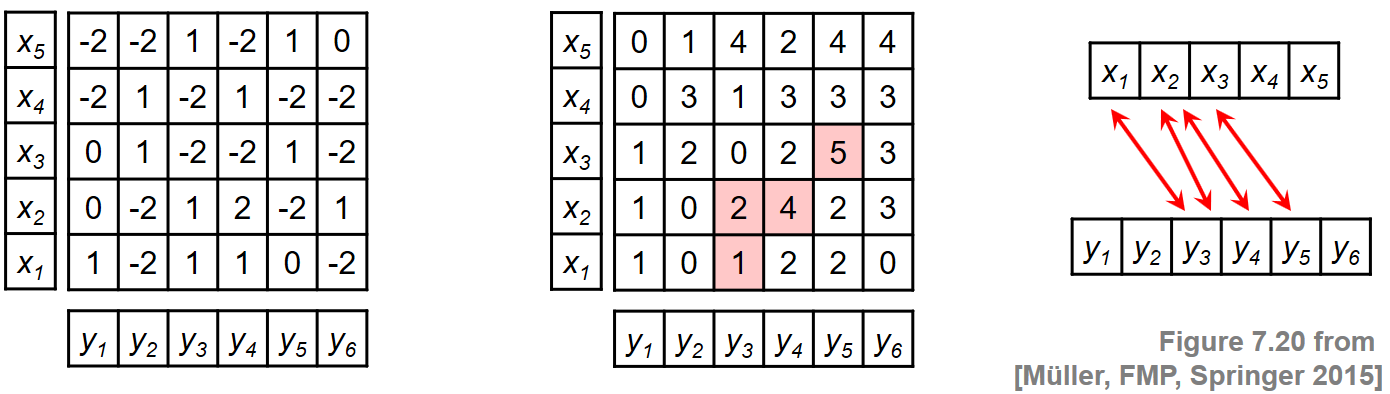

In [13]:
Image(path_img+"FMP_C7_F20.png", width="600px")

In [14]:
# Example from Figure 7.20, [Müller, FMP, Springer 2015]
S = np.array([[1,  -2,  1,  1,  0, -2],
              [0,  -2,  1,  2, -2,  1],
              [0,   1, -2, -2,  1, -2],
              [-2,  1, -2,  1, -2, -2],
              [-2, -2,  1, -2,  1,  0]])

print('Score matrix S = ', S, sep='\n')

Score matrix S = 
[[ 1 -2  1  1  0 -2]
 [ 0 -2  1  2 -2  1]
 [ 0  1 -2 -2  1 -2]
 [-2  1 -2  1 -2 -2]
 [-2 -2  1 -2  1  0]]


In [15]:
def compute_accumulated_score_matrix_common_subsequence(S):
    """Given the score matrix, compute the accumulated score matrix
    for common subsequence matching with step sizes {(1, 0), (0, 1), (1, 1)}

    Args:
        S (np.ndarray): Score matrix

    Returns:
        D (np.ndarray): Accumulated score matrix
    """
    N, M = S.shape
    D = np.zeros((N, M))

    D[0, 0] = max(0, S[0, 0])

    for n in range(1, N):
        D[n, 0] = max(0, D[n-1, 0] + S[n, 0])

    for m in range(1, M):
        D[0, m] = max(0, D[0, m-1] + S[0, m])

    for n in range(1, N):
        for m in range(1, M):
            D[n, m] = max(0, D[n-1, m-1] + S[n, m], D[n-1, m] + S[n, m], D[n, m-1] + S[n, m])

    return D

In [16]:
D = compute_accumulated_score_matrix_common_subsequence(S)
Dmax = np.max(D)
n, m = divmod(np.argmax(D), D.shape[1])
print('Accumulated score matrix D = ', D, sep='\n')
print('Maximal accumulated score Dmax = ', Dmax)
print('Maximizing cell (n,m) = (%d,%d)' % (n, m))

Accumulated score matrix D = 
[[1. 0. 1. 2. 2. 0.]
 [1. 0. 2. 4. 2. 3.]
 [1. 2. 0. 2. 5. 3.]
 [0. 3. 1. 3. 3. 3.]
 [0. 1. 4. 2. 4. 4.]]
Maximal accumulated score Dmax =  5.0
Maximizing cell (n,m) = (2,4)


- 마지막으로 역추적을 사용하여 최적 경로 $P^\ast$와 유도된 세그먼트 $\pi_1(P^\ast)$와 $\pi_2(P^\ast)$를 얻는다.

In [17]:
def compute_optimal_path_common_subsequence(D, cellmax=True, n=0, m=0):
    """Given an accumulated score matrix, compute the score-maximizing path
    for common subsequence matching with step sizes {(1, 0), (0, 1), (1, 1)}

    Args:
        D (np.ndarray): Accumulated score matrix
        cellmax (bool): If "True", score-maximizing cell will be computed (Default value = True)
        n (int): Index (first axis) of cell for backtracking start; only used when cellmax=False (Default value = 0)
        m (int): Index (second axis) of cell for backtracking start; only used when cellmax=False (Default value = 0)

    Returns:
        P (np.ndarray): Score-maximizing path (array of index pairs)
    """
    if cellmax:
        # n, m = np.unravel_index(np.argmax(D), D.shape)  # doesn't work with jit
        n, m = divmod(np.argmax(D), D.shape[1])
    P = [(n, m)]

    while ((n, m) != (0, 0) and (D[n, m] != 0)):
        if n == 0:
            cell = (0, m-1)
        elif m == 0:
            cell = (n-1, 0)
        else:
            val = max(D[n-1, m-1], D[n-1, m], D[n, m-1])
            if val == D[n-1, m-1]:
                cell = (n-1, m-1)
            elif val == D[n-1, m]:
                cell = (n-1, m)
            else:
                cell = (n, m-1)
        P.append(cell)
        n, m = cell
    if (D[n, m] == 0):
        del P[-1]
    P.reverse()
    P = np.array(P)
    return P


def get_induced_segments(P):
    """Given a path, compute the induces segments

    Args:
        P (np.ndarray): Path (list of index pairs)

    Returns:
        seg_X (np.ndarray): Induced segment of first sequence
        seg_Y (np.ndarray): Induced segment of second sequence
    """
    seg_X = np.arange(P[0, 0], P[-1, 0] + 1)
    seg_Y = np.arange(P[0, 1], P[-1, 1] + 1)
    return seg_X, seg_Y


P = compute_optimal_path_common_subsequence(D)
seg_X, seg_Y = get_induced_segments(P)

print('Optimal path P =', P, sep='\n')
print('Induced segment for X:', seg_X)
print('Induced segment for Y:', seg_Y)

Optimal path P =
[[0 2]
 [0 3]
 [1 3]
 [2 4]]
Induced segment for X: [0 1 2]
Induced segment for Y: [2 3 4]


In [18]:
# a sanity check

score_P = sum(S[n, m] for (n, m) in P)
print('Total score of optimal path:', score_P)
print('Maximal accumulated score Dmax = ', Dmax)

Total score of optimal path: 5
Maximal accumulated score Dmax =  5.0


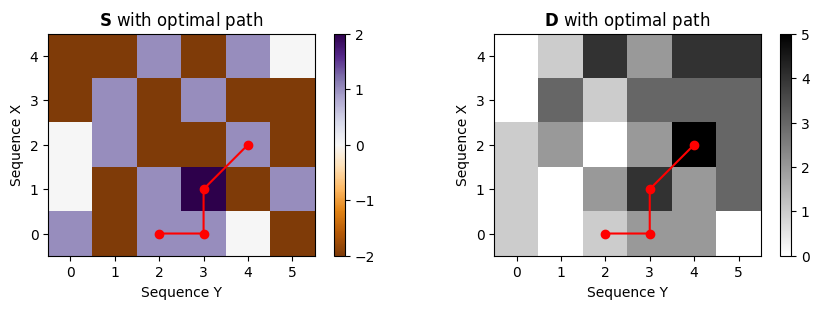

In [19]:
plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
plt.imshow(S, cmap='PuOr', origin='lower', aspect='equal')
plt.plot(P[:, 1], P[:, 0], marker='o', color='r')
plt.clim([np.min(S), np.max(S)])
plt.colorbar()
plt.title('$\mathbf{S}$ with optimal path')
plt.xlabel('Sequence Y')
plt.ylabel('Sequence X')

plt.subplot(1, 2, 2)
plt.imshow(D, cmap='gray_r', origin='lower', aspect='equal')
plt.plot(P[:, 1], P[:, 0], marker='o', color='r')
plt.clim([0, np.max(D)])
plt.colorbar()
plt.title('$\mathbf{D}$ with optimal path')
plt.xlabel('Sequence Y')
plt.ylabel('Sequence X')

plt.tight_layout()

## 부분 매칭 (Partial Matching)

- **단계 크기(step size) 조건**을 훨씬 더 약한 **단조성(monotonicity) 조건**으로 대체하여 정렬 요구 사항을 더 완화할 수 있다. 이에 대해 **부분 매칭**라는 최적화 문제를 생각할 수 있다.

- 이 문제를 공식화하고 동적 프로그래밍을 기반으로 효율적인 알고리즘을 보도록 한다. $X=(x_1,x_2,\ldots,x_N)$ 및 $Y=(y_1,y_2,\ldots,y_M)$가 특징 공간 $\mathcal{F}$에 대한 두 시퀀스라고 가정한다. $X$와 $Y$ 사이의 길이 $L\in\mathbb{N}_0$의 **부분 매칭**은 셀 $(n_\ell,m_\ell)\in[1:N]\times[1:M]$, $\ell\in[1:L]$의 시퀀스 $P=((n_1,m_1), \ldots,(n_L, m_L))$로 정의되며, 강하게 단조 증가한다:
    - $n_1<n_2<\ldots < n_L \quad\mbox{and}\quad m_1< m_2< \ldots < m_L.$

- 유사성 척도 $s:\mathcal{F}\times\mathcal{F}\to \mathbb{R}$가 주어지면 유사성 행렬 $\mathbf{S}$를 $\mathbf{S}(n ,m):=s(x_{n},y_{m})$로 정의한다. 그런 다음 부분 매칭 $P$의 총 점수 $\sigma(P)$는 $ \sigma(P) := \sum_{\ell = 1}^{L} \mathbf{S}(n_\ell,m_\ell)$로 구체화된다.

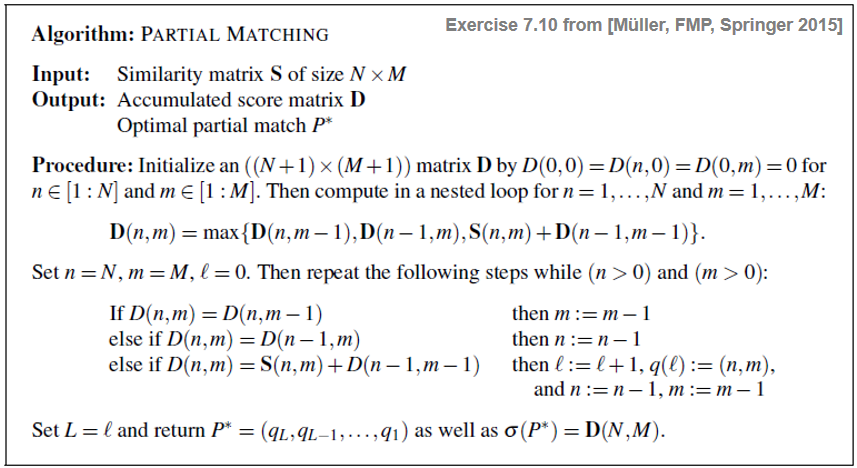

In [20]:
Image(path_img+"FMP_C7_E10.png", width="600px")

- nested 루프에서 점수 값 $\mathbf{S}(n,m)$는 DTW 알고리즘과 달리 대각선 스텝 크기의 경우에만 추가된다. 여기서 비용 값 $\mathbf{C}(n,m)$는 세 스텝 크기 모두의 경우에 추가된다. 또한 누적 점수 $\mathbf{D}(n,m)$를 산출하는 최적의 부분 매칭은 $\mathbf{D}(n,m)$를 산출하는 최적의 워핑 경로가 항상 $(n,m)$ 셀로 끝나는 DTW 알고리즘과 달리 반드시 셀 $(n,m)$에서 끝나지는 않는다.

- 다음 코드 셀에서는 부분 매칭 절차에 대한 참조 구현을 제공한다.

In [21]:
def compute_partial_matching(S):
    """Given the score matrix, compute the accumulated score matrix
    for partial matching

    Args:
        S (np.ndarray): Score matrix

    Returns:
        D (np.ndarray): Accumulated score matrix
        P (np.ndarray): Partial match (array of index pairs)
    """
    N, M = S.shape
    D = np.zeros((N+1, M+1))
    for n in range(1, N+1):
        for m in range(1, M+1):
            D[n, m] = max(D[n, m-1], D[n-1, m], D[n-1, m-1] + S[n-1, m-1])

    P = []
    n = N
    m = M
    while (n > 0) and (m > 0):
        if D[n, m] == D[n, m-1]:
            m = m - 1
        elif D[n, m] == D[n-1, m]:
            n = n - 1
        else:
            P.append((n-1, m-1))
            n = n - 1
            m = m - 1
    P.reverse()
    P = np.array(P)
    return D, P

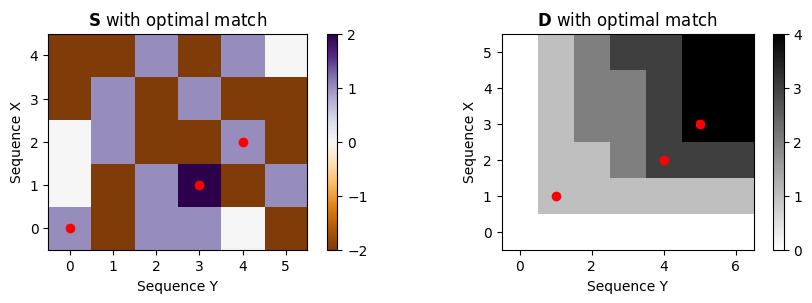

In [22]:
D, P = compute_partial_matching(S)

plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
plt.imshow(S, cmap='PuOr', origin='lower', aspect='equal')
plt.plot(P[:, 1], P[:, 0], marker='o', color='r', linestyle='')
plt.clim([np.min(S), np.max(S)])
plt.colorbar()
plt.title('$\mathbf{S}$ with optimal match')
plt.xlabel('Sequence Y')
plt.ylabel('Sequence X')

plt.subplot(1, 2, 2)
plt.imshow(D, cmap='gray_r', origin='lower', aspect='equal')
plt.plot(P[:, 1]+1, P[:, 0]+1, marker='o', color='r', linestyle='')
plt.clim([0, np.max(D)])
plt.colorbar()
plt.title('$\mathbf{D}$ with optimal match')
plt.xlabel('Sequence Y')
plt.ylabel('Sequence X')

plt.tight_layout()

# 버전 식별 (Version Identification)

- **버전 식별**(**version identification**)이라는 작업이 있으며 이느 **커버 송 검색**(**cover song retrieval**)이라고도 불린다. 음악 작품의 녹음(또는 그 일부)이 주어지면 버전 식별은 음악 컬렉션에서 동일한 작품의 모든 녹음 버전(예: 커버 곡)을 자동으로 검색하는 것을 목표로 한다.
    * 버전 식별에서 쿼리는 일반적으로 쿼리가 작은 오디오 조각인 **오디오 식별** 및 **오디오 매칭**과 달리 전체 녹음으로 구성되다.
    * 따라서 버전 식별은 일반적으로 전체 문서를 전체적으로 비교하기 위해 단일 유사성 측정이 사용되는 **문서 수준**(document-level) 검색 작업으로 간주된다.
    * 버전 식별의 기본 가정은 음악 작품의 원본 버전과 파생 버전이 일반적으로 몇 가지 공통된 특성을 공유한다는 것이다. 그러나 버전 간의 가능한 구조적(structural) 차이로 인해 이러한 공통 요소가 발생하는 위치가 명확하지 않다.
    * 주어진 쿼리 문서와 데이터베이스 문서 간의 **전역**(global) 유사성을 평가할 때 버전 식별의 일반적인 전략은 특정 음악적 속성과 관련하여 **로컬**(local) 동시성을 찾는 것이다. 즉, 전역 비교는 로컬 기준으로 수행된다.

- 새 버전을 만들 때 적용될 수 있는 많은 종류의 수정을 고려할 때, 단일 기술을 사용하여 모든 변형을 처리할 수 있다고 가정하는 것은 현실적이지 않다.
- 다음에서는 식별할 버전이 적어도 특정 섹션에서 유사한 **선율** 또는 **화성 진행**을 공유하는 경우로 제한한다. 반면에 템포, 악기 편성, 음색, 전체적인 음악적 구조와 같은 측면에서의 차이는 허용한다.

- 임의 길이의 두 개의 오디오 녹음(문서라고도 함)이 주어지면 단계는 다음과 같다.
     * 먼저 음조(tonal) 특성을 캡처하기 위해 녹음을 **크로마 기반 오디오 특징**의 시퀀스로 변환한다.
     * 둘째, **점수 행렬**(또는 **유사성 행렬**)은 이 두 시퀀스의 요소를 쌍(pairs)으로 비교하여 계산된다.
     * 셋째, 잠재적으로 긴 **높은 유사성의 경로**를 식별한다. 이러한 경로의 존재는 두 크로마 시퀀스가 일부 관련 하위 시퀀스를 공유함을 나타낸다.
     * 마지막으로 이 정보에서 비교할 두 버전 간의 **유사성 점수**를 도출한다.

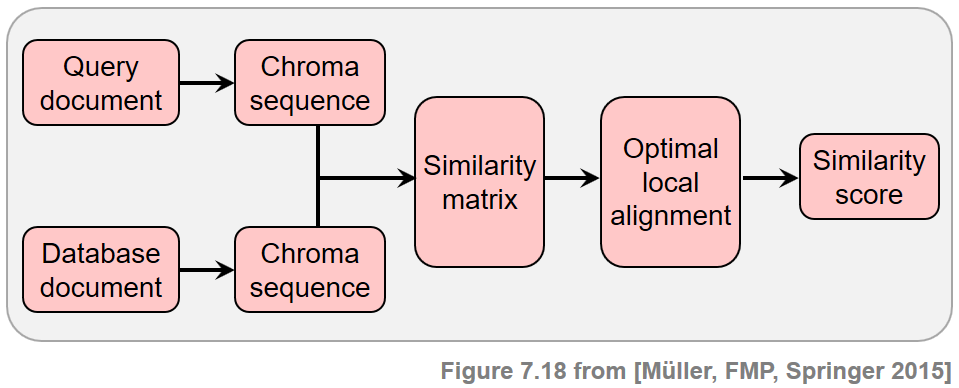

In [26]:
Image(path_img+"FMP_C7_F18.png", width="600px")

## Computation of Score Matrix

In the first step, both the query and the database document are converted into chroma-based feature sequences, say $X=(x_1,x_2,\ldots,x_N)$  and  $Y=(y_1,y_2,\ldots,y_M)$. Since we want to blend out nuances, the usage of a smoothed and normalized chroma variant such as the [CENS features](../C7/C7S2_CENS.html) is beneficial. In version identification, similar to the [audio matching](../C7/C7S2_AudioMatching.html) application, a feature rate of $2~\mathrm{Hz}$ (two chroma vectors per second) constitutes a good trade-off between robustness and specificity. 

Given the sequences $X$ and $Y$, we are now looking for a subsequence within $X$ and a subsequence within $Y$ such that these two subsequences are as similar as possible. To this end, we compute a **local alignment** using the technique as described in the [FMP notebook on common subsequence matching](../C7/C7S3_CommonSubsequence.html). To employ this score-maximizing alignment technique, one needs to input a score matrix that encodes potential relations between $X$ and $Y$ by cells with positive score and irrelevant information by cells with negative score. To construct such a score matrix we apply similar techniques as used in the [FMP notebook on audio thumbnailing](../C4/C4S3_AudioThumbnailing.html), where we constructed a [self-similarity matrix](../C4/C4S2_SSM.html).

* We obtain a first score matrix by comparing the elements of the sequences $X$ and $Y$ in a pairwise fashion. In our case, we use the inner product applied to normalized CENS vectors as local similarity measure.
* Paths of high similarity in this matrix indicate similar subsequences. To enhance this relevant information, we apply [path enhancement strategies](../C4/C4S2_SSM-PathEnhancement.html).
* To account for different musical keys, one may apply the same idea as was used in the [FMP notebook on transposition-invariant SSMs](../C4/C4S2_SSM-TranspositionInvariance.html).
* To obtain a balance between positive and and negative values, we apply a [thresholding procedure](../C4/C4S2_SSM-Thresholding.html) with normalization and penalty. In particular, we use a relative strategy (`strategy = relative`) for thresholding keeping $15$ percent of the cells with the highest values (`thresh=0.15`). Furthermore, we rescale the positive range between zero and one (`scale=1`). All other cells are considered irrelevant and are set to a negative score value (`penalty=-2`).

In the following code cell, we provide an implementation for computing such a score matrix, which is then shown for the song "Day Tripper." The vertical axis corresponds to the original Beatles version, whereas the horizontal axis corresponds to the cover version by Ocean Colour Scene.

In [27]:
def compute_sm_from_wav(x1, x2, Fs, N=4410, H=2205, ell=21, d=5, L_smooth=12,
                        tempo_rel_set=np.array([0.66, 0.81, 1, 1.22, 1.5]),
                        shift_set=np.array([0]), strategy='relative', scale=True,
                        thresh=0.15, penalty=-2.0, binarize=False):
    """Compute a similarity matrix (SM)

    Args:
        x1 (np.ndarray): First signal
        x2 (np.ndarray): Second signal
        Fs (scalar): Sampling rate of WAV files
        N (int): Window size for computing STFT-based chroma features (Default value = 4410)
        H (int): Hop size for computing STFT-based chroma features (Default value = 2205)
        ell (int): Smoothing length for computing CENS features (Default value = 21)
        d (int): Downsampling factor for computing CENS features (Default value = 5)
        L_smooth (int): Length of filter for enhancing SM (Default value = 12)
        tempo_rel_set (np.ndarray): Set of relative tempo values for enhancing SM
            (Default value = np.array([0.66, 0.81, 1, 1.22, 1.5]))
        shift_set (np.ndarray): Set of shift indices for enhancing SM (Default value = np.array([0]))
        strategy (str): Thresholding strategy for thresholding SM ('absolute', 'relative', 'local')
            (Default value = 'relative')
        scale (bool): If scale=True, then scaling of positive values to range [0,1] for thresholding SM
            (Default value = True)
        thresh (float): Treshold (meaning depends on strategy) (Default value = 0.15)
        penalty (float): Set values below treshold to value specified (Default value = -2.0)
        binarize (bool): Binarizes final matrix (positive: 1; otherwise: 0) (Default value = False)

    Returns:
        X (np.ndarray): CENS feature sequence for first signal
        Y (np.ndarray): CENS feature sequence for second signal
        Fs_feature (scalar): Feature rate
        S_thresh (np.ndarray): Similarity matrix
        I (np.ndarray): Index matrix
    """
    # Computation of CENS features
    C1 = librosa.feature.chroma_stft(y=x1, sr=Fs, tuning=0, norm=1, hop_length=H, n_fft=N)
    C2 = librosa.feature.chroma_stft(y=x2, sr=Fs, tuning=0, norm=1, hop_length=H, n_fft=N)
    Fs_C = Fs / H
    X, Fs_feature = libfmp.c7.compute_cens_from_chromagram(C1, Fs_C, ell=ell, d=d)
    Y, Fs_feature = libfmp.c7.compute_cens_from_chromagram(C2, Fs_C, ell=ell, d=d)

    # Compute enhanced SM
    S, I = libfmp.c4.compute_sm_ti(X, Y, L=L_smooth,  tempo_rel_set=tempo_rel_set,
                                   shift_set=shift_set, direction=2)
    S_thresh = libfmp.c4.threshold_matrix(S, thresh=thresh, strategy=strategy,
                                          scale=scale, penalty=penalty, binarize=binarize)
    return X, Y, Fs_feature, S_thresh, I

In [ ]:
fn1 = os.path.join('..', 'data', 'C7', 'FMP_C7_F19_TheBeatles_DayTripper_TheBeatles.wav')
fn2 = os.path.join('..', 'data', 'C7', 'FMP_C7_F19_TheBeatles_DayTripper_OceanColourScene.wav')
Fs = 22050
x1, Fs = librosa.load(fn1, sr=Fs)
x2, Fs = librosa.load(fn2, sr=Fs)

penalty=-2
tempo_rel_set=np.array([0.8, 1, 1.2])
L_smooth = 20
X, Y, Fs_X, S, I = compute_sm_from_wav(x1, x2, Fs, tempo_rel_set = tempo_rel_set,
                                              L_smooth=L_smooth, penalty=penalty)

cmap_penalty = libfmp.c4.colormap_penalty(penalty=penalty)

figsize=(8, 4)
libfmp.b.plot_matrix(S, figsize=figsize, cmap=cmap_penalty, 
                     Fs=Fs_X, Fs_F=Fs_X, aspect='equal',
                     title='Score matrix $\mathbf{S}$', 
                     xlabel='Time (seconds) [Ocean Colour Scene]', 
                     ylabel='Time (seconds) [Beatles]')

plt.tight_layout()